In [29]:
# !pip install mahotas

In [30]:
# from mahotas.features import zernike_moments
from concurrent.futures import ProcessPoolExecutor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
import shutil
import os

# Load Data

In [31]:
image_dir = '/kaggle/input/logo-similarity-data/data/extracted_logos/'
output_dir = '/kaggle/working/labeled_data'
os.makedirs(output_dir, exist_ok=True)

# Transforms

In [32]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop((40, 40)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485],  # imagenet means/stds
                         std=[0.229]),
    # transforms.GaussianBlur(51),
    # transforms.GaussianBlur(51),
    # transforms.GaussianBlur(31),
])

def remove_transparency(im, bg_color=(255, 255, 255)):
    if im.mode == 'RGBA':
        # Create white RGB background and paste RGBA onto it using alpha
        bg = Image.new('RGB', im.size, bg_color)
        bg.paste(im, mask=im.split()[-1])  # Use alpha channel as mask
        return bg

    elif im.mode == 'LA':
        # Create white L background and paste LA onto it using alpha
        bg = Image.new('L', im.size, bg_color[0])  # Use first channel for grayscale
        bg.paste(im.convert('L'), mask=im.split()[-1])
        return bg

    elif im.mode in ('RGB', 'L'):
        return im  # No transparency — return as is

    else:
        # For any other mode, convert to RGB
        return im.convert('RGB')

def add_gaussian_noise(img, mean=0, std=1):
    return img + torch.randn_like(img) * std + mean

# Pre Processing

In [33]:
def process_image_from_path(path, channel='LA'):
    img = Image.open(path).convert(channel)
    img = remove_transparency(img)
    img = transform(img)
    # img = add_gaussian_noise(img)
    # img_np = img.permute(1, 2, 0).numpy()
    return img

# Show random image

Text(0.5, 1.0, 'esseskincare.dk.png')

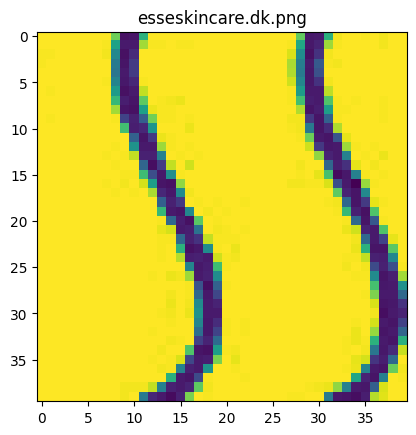

In [34]:
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

idx = np.random.randint(len(image_files))

path = os.path.join(image_dir, image_files[idx])
img = process_image_from_path(path, channel='LA')
img = img.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.title(image_files[idx])


In [35]:
raw_images = []
for filename in tqdm(image_files, desc="Loading and flattening images"):
    path = os.path.join(image_dir, filename)

    img_tensor = process_image_from_path(path, channel='LA')
    
    flat_tensor = img_tensor.view(-1)
    raw_images.append(flat_tensor)

Loading and flattening images: 100%|██████████| 3356/3356 [00:06<00:00, 501.32it/s]


In [36]:
hyperparams = {
    'eps': 2,
    'min_samples': 2
}

# Train Model

In [37]:
dbscan = DBSCAN(eps=hyperparams['eps'], min_samples=hyperparams['min_samples'])
labels = dbscan.fit_predict(raw_images)

# Delete old dir

In [38]:
!rm -rf labeled_data
os.makedirs(output_dir, exist_ok=True)

# Correlate label and domain

In [39]:
for filename, label in zip(image_files, labels):
    old_path = os.path.join(image_dir, filename)
    new_filename = f"{label}_{filename}"
    new_path = os.path.join(output_dir, new_filename)
    shutil.copy2(old_path, new_path)

# Count noise found

In [40]:
!find labeled_data -maxdepth 1 -type f -name '-1*' | wc -l

1794


# Count total files

In [41]:
!find labeled_data -maxdepth 1 -type f | wc -l

3356


# Save .zip

In [42]:
!zip -r labeled_data.zip labeled_data

updating: labeled_data/ (stored 0%)
updating: labeled_data/-1_amtrakvacations.com.au.png (deflated 29%)
updating: labeled_data/-1_mazdaofnewrochelle.com.png (deflated 1%)
updating: labeled_data/-1_veolia.be.png (stored 0%)
updating: labeled_data/-1_malerasstockholm.se.png (stored 0%)
updating: labeled_data/-1_pamline.fr.png (deflated 2%)
updating: labeled_data/-1_veoliawatertech.com.png (deflated 3%)
updating: labeled_data/-1_wurth.es.png (deflated 0%)
updating: labeled_data/-1_isover.at.png (deflated 4%)
updating: labeled_data/-1_bosch-pt.com.cn.png (stored 0%)
updating: labeled_data/-1_aliaxis.cz.png (deflated 2%)
updating: labeled_data/-1_hps-guns.de.png (deflated 3%)
updating: labeled_data/-1_tryg.com.png (deflated 2%)
updating: labeled_data/-1_statkraft.nl.png (stored 0%)
updating: labeled_data/-1_deheus.co.in.png (stored 0%)
updating: labeled_data/-1_engieresources.com.png (deflated 3%)
updating: labeled_data/-1_customneon.com.au.png (deflated 2%)
updating: labeled_data/-1_boxful